# Exercise: TKO_3120 Machine Learning and Pattern Recognition

Oskari Noppa

Student number: 509365

# The problem
CIFAR-10 is a dataset consist of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The test images are composed of 1000 randomly selected images from each class. The training images contains 5,000 images from each class in random order. The goal of this execrisce, is to build an algorithm which takes a random image and classify it to one of the 10 classes with as high as possible accuracy.

# Import Packages
Import all the packages needed for this notebook in one cell

In [1]:
5 + 2

7

In [194]:
import numpy as np
import os
import platform
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import cv2

from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Load the raw CIFAR-10 data

Donwnload the dataset from the zip file (cifar-10-batches-py) in moodle. Then unzip the file. 

In [4]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

In [5]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [6]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

In [7]:
# Load the raw CIFAR-10 data.
# Note: Path changed from the original in excercise template
cifar10_dir = '/cifar10'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [126]:
train_len = len(X_train)
X_both = np.concatenate((X_train, X_test))
X_both.shape

(60000, 32, 32, 3)

# Data Visualization

Show a few examples of training images from each class.

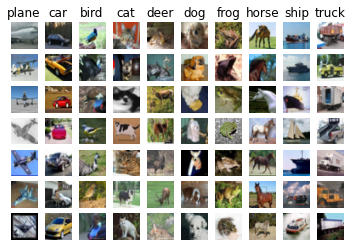

In [8]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Feature extraction



## 1- Color Mean and Standard Deviation
**Question (1 point):** 
Calculate the below mentioned color features for each image:

- Mean for each RGB color channel
- Standard Deviation (STD) for each RGB color channel


In [71]:
import itertools
def flatten(arr):
    return list(itertools.chain.from_iterable(arr))

In [127]:
def rgb_feature(image, fun):
    rgb = [image[:,:,i] for i in range(0, 3)]
    return np.fromiter(map(fun, rgb), float)

mean = np.array([rgb_feature(img, np.mean) for img in X_both])
std = np.array([rgb_feature(img, np.std) for img in X_both])

In [128]:
std.shape

(60000, 3)

## 2- Color Histograms
**Question (1 point):**

   Obtain histogram feature  (e.g. cv2.calcHist from OpenCV) for each of RGB channel with 8 bins per channel. 

In [129]:
def channel_histogram(image, channel):
    return flatten(cv2.calcHist(image.astype('float32'), [channel], None, [8], [0, 256]))

def get_histograms(image):
    return np.array([channel_histogram(image, channel) for channel in range(0, 3)])

# histograms = map(lambda img: flatten(flatten(get_histograms(img))), X_train)
histograms = np.array([get_histograms(img) for img in X_both])

In [109]:
def convert_3to2_dimensions(mat):
    (x, y, z) = mat.shape
    return mat.reshape(x, y * z)

In [130]:
histograms = convert_3to2_dimensions(histograms)
histograms.shape

(60000, 24)

## 3- Local Binary Patterns (LBP)
**Question (1 point):**
Create Local Binary Pattern of each image 

    

In [133]:
def get_lbp(image):
  gray = rgb2gray(image)
  return local_binary_pattern(gray, 8, 1)

lbp = np.array([get_lbp(img) for img in X_both])

In [134]:
lbp = convert_3to2_dimensions(lbp)
lbp.shape

(60000, 1024)

Gather all features (Mean, std, HIS and LBP) into an input array X, and the image classes into an output array y. Standardize the
feature values in X. One standard way of doing it is zscore normalization, meaning that the feature values will have zero mean and unit variance.

In [135]:
X = np.column_stack([mean, std, histograms, lbp])

In [136]:
scaler = StandardScaler()
standardized = scaler.fit_transform(X)
standardized

array([[ 0.48219019, -0.56099001, -1.27893206, ..., -1.06279116,
         0.36198104,  0.00212865],
       [ 0.14585251,  0.22744275,  0.42075853, ..., -1.00209071,
        -1.06617114,  0.00212865],
       [ 0.24624647,  0.37682808,  0.47467096, ..., -1.00209071,
        -1.0066648 , -0.98842323],
       ...,
       [-1.82146928, -2.01114313, -1.50864699, ...,  0.81892303,
        -0.35209505,  0.74504257],
       [-0.59253853, -0.14382644, -0.60142917, ...,  0.75822257,
         0.6000064 ,  0.74504257],
       [-0.3777241 , -0.28199721, -0.4412408 , ..., -0.33438567,
         0.36198104,  0.74504257]])

## PCA 
**Question (1 point):** 

Use PCA with 10 component to reduce dimension of the feature vector X.

In [140]:
pca = PCA(n_components=10)
X_transformed = pca.fit_transform(standardized)
X_train_transformed = X_transformed[:train_len]
X_test_transformed = X_transformed[train_len:]

print("Train data shape: ", X_train_transformed.shape)
print("Test data shape: ", X_test_transformed.shape)

Train data shape:  (50000, 10)
Test data shape:  (10000, 10)


# Build classifiers and estimate their performance

## 1- K-Nearest Neighbor (K-NN) 

In this exercise you will implement a K-NN classifier and understand the basic Image Classification pipeline and  cross-validation.

**Question (2 points):** 

Perform 5-fold cross validation to find the best value of k in range 1 to 30. For each possible value of k, run the k-nearest-neighbor algorithm num_folds times (5),   where in each case you use all but one of the folds as training data and the last fold as a validation set.                   



In [188]:
def get_accuracy(k):
  scores = []
  f = StratifiedKFold(n_splits=5)
  for train_idx, test_idx in f.split(X_train_transformed, y_train):
    x_train_, x_test_ = X_train_transformed[train_idx], X_train_transformed[test_idx]
    y_train_, y_test_ = y_train[train_idx], y_train[test_idx]

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_, y_train_)
    score = knn.score(x_test_, y_test_)
    scores.append(score)

  score_mean = np.mean(scores)
  return (k, score_mean)

accuracies = [get_accuracy(x) for x in range(1,31)]

In [189]:
accuracies

[(1, 0.20742000000000002),
 (2, 0.19276000000000001),
 (3, 0.21139999999999998),
 (4, 0.22434000000000004),
 (5, 0.23286),
 (6, 0.24008000000000002),
 (7, 0.24322),
 (8, 0.24764),
 (9, 0.25068),
 (10, 0.25436000000000003),
 (11, 0.25652),
 (12, 0.25904),
 (13, 0.26098),
 (14, 0.26110000000000005),
 (15, 0.2629),
 (16, 0.26576000000000005),
 (17, 0.26639999999999997),
 (18, 0.26705999999999996),
 (19, 0.26659999999999995),
 (20, 0.26820000000000005),
 (21, 0.27006),
 (22, 0.27071999999999996),
 (23, 0.27152),
 (24, 0.27302),
 (25, 0.27455999999999997),
 (26, 0.27524),
 (27, 0.27446000000000004),
 (28, 0.27674),
 (29, 0.27714),
 (30, 0.27792)]

**Question (1 point):** 

- Plot the Cross-validated accuracy based on the different value of k

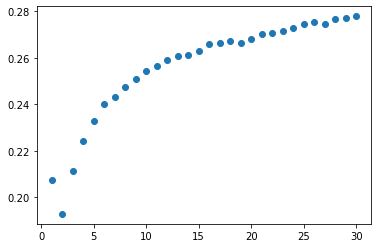

In [190]:
plt.scatter(*zip(*accuracies))
plt.show()

**Questions (2 points):** 
    
- Based on the cross-validation results above, choose the best value for k,   

- Retrain the classifier using all the training data, and test it on the test data. 

- What is the accuracy value for the test data?

In [191]:
best_k_acc_idx = np.argmax([acc for (k, acc) in accuracies])
best_k = accuracies[best_k_acc_idx][0]
print("Best value for k: ", best_k)

Best value for k:  30


In [192]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_transformed, y_train)
score = knn.score(X_test_transformed, y_test)
print("Accuracy value for the test data: ", score)

Accuracy value for the test data:  0.2711


## 2- Logistic Regression (LR)


In this exercise you will implement a LR classifier.

**Question (2 points):** 

- Create and train the Logistic Regression model
- Calculate the accuracy and the confusion matrix on test dataset

In [193]:
lr_model = LogisticRegression()
lr_model.fit(X_train_transformed, y_train)

LogisticRegression()

In [215]:
predictions = lr_model.predict(X_test_transformed)
predictions

array([4, 1, 8, ..., 0, 1, 7])

In [222]:
print("LR model accuracy: ", metrics.accuracy_score(y_test, predictions))

LR model accuracy:  0.2293


In [216]:
metrics.confusion_matrix(y_test, predictions)

array([[251,  86,  36,  25,  57,  63,  67, 112, 189, 114],
       [ 58, 357,  18,  21,  64,  54,  94,  64,  92, 178],
       [115,  70,  50,  36, 206, 113, 110, 132, 133,  35],
       [ 85,  92,  52,  69, 133, 147, 143, 110, 100,  69],
       [ 71,  83,  50,  33, 248, 129, 163, 102,  95,  26],
       [ 86,  76,  50,  57, 118, 194, 137, 107, 121,  54],
       [ 56,  64,  32,  51, 213, 100, 260,  81,  59,  84],
       [ 99,  96,  38,  28, 115,  71,  63, 281, 135,  74],
       [127, 149,  29,  24,  67,  72,  60, 101, 255, 116],
       [115, 197,   7,  20,  50,  35,  41, 118,  89, 328]])

## 3- Multilayer perceptron 
In this exercise you will develop a neural network with one hidden layer to perform classification.

Use:

- solver for weight optimization: stochastic gradient-based optimizer ('sgd')
- activation function for the hidden layer: rectified linear unit function ('relu')
- Early stop

**Questions (3 points):** 
- What is the prediction accuracy for the test data?
-  To evaluate the MLP model, calculate the metrics such as a confusion matrix, precision, recall, and f1 score. 
-  Show the predicted results (classification lable) on 5 random example of test dataset.
- Show 5 random of wrong predictions